In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from collections import Counter
from random import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Grab MTG oracle information (bulk data downloaded from Scryfall) to match cardnames to mana value
all_cards = pd.read_json('oracle-cards-20210615090438.json')
all_cards[['name','cmc']].head()

,name,cmc
0,Static Orb,3.0
1,Sensory Deprivation,1.0
2,Road of Return,2.0
3,Storm Crow,2.0
4,Walking Sponge,2.0


In [3]:
def give_cmc(cardname):
    """Given a cardname, returns the cmc"""
    relevant_rows = all_cards[all_cards['name']==cardname]
    #Normally, if there's only one card with name equal to cardname in the Oracle text, then there will be one row
    #But Magic is weird so we have to cover some exceptions
    if len(relevant_rows.index) == 0:
        #We're searching for, e.g., "Hagra Mauling" when the dataframe contains "Hagra Mauling // Hagra Broodpit"
        #So take the rows where the 'name' column starts with "Hagra Mauling //"
        relevant_rows = all_cards[all_cards['name'].str.match(cardname+" //")]
    #We should now always have exactly 1 relevant_row unless there's also an art series or token with the same name
    #We only want normal cards or modal_dfcs
    if len(relevant_rows.index) != 1:
        relevant_rows = relevant_rows[(relevant_rows['layout'] == 'modal_dfc') | (relevant_rows['layout'] == 'normal')]
    #This should cover all exceptions, as far as I can tell. Just in case, print an error to indicate what's up
    if len(relevant_rows.index) != 1:
        print("Issue with ",cardname)
    cmc = relevant_rows.cmc.iloc[0]
    return cmc

def give_decklists(mtg_format):
    """Given format such as 'Legacy' or 'Standard' returns a list of decks, where each deck is modeled as a cmc distribution
    So we'll return, e.g., [{0: 20, 1: 20, 2: 20, 3: 0, 4: 0, ..., 15: 0}, {0: 30, 1: 10, 2: 10, 3: 10, 4: 0, ..., 15: 0}]
    """
    list_of_decks = []
    if mtg_format in ['Legacy', 'Modern', 'Vintage']:
        #From the MTGO decklist page, I downloaded all available decklists for that format of the Jun 7&13&14 challenges
        #I then copied each text file to the correspondingly named folder so we'll grab it from there
        #Start by getting list of filenames from the corresponding directory, into variable onlyfiles
        mypath = mtg_format
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        for filename in onlyfiles:
            with open(mtg_format + '/' + filename, encoding="utf-8") as f:
                text = f.read()
                #In each text file as downloaded from WotC, maindeck and sideboard are split by two empty lines
                maindeck = text.split('\n\n')[0]
                #Maindeck is now a string like '4 Champion of the Parish\n2 Esper Sentinel\n ...'
                #Turn this into a list of rows, so ['4 Champion of the Parish', '2 Esper Sentinel', ...]
                maindeck_cards = maindeck.split('\n')
                #We want to obtain a dictionary cmc_dist so that cmc_dist[cmc] is the number of cards of that cmc in this deck
                #We'll also store the actual decklist for reference in cmc_dist[decklist]
                cmc_dist = {cmc: 0 for cmc in range(16)}
                cmc_dist['decklist'] = maindeck_cards
                for card in maindeck_cards:
                    number, cardname = card.split(" ", 1)
                    cmc = give_cmc(cardname)
                    cmc_dist[cmc] += int(number)
                #Add this dictionary to list_of_decks
                list_of_decks.append(cmc_dist)
    if mtg_format in ['Standard', 'Historic']:
        #I'll use json downloaded from the MTG Melee tournament controller, which I obtained for doing WotC's metagame breakdown
        df = pd.read_json("Decklists - WOTC - "+mtg_format+" - Strixhaven Championship.json",encoding='latin1')
        #df.MAIN_DECK has a list of main decks in this event in the form ['4 Champion of the Parish', '2 Esper Sentinel', ...]
        for maindeck_cards in df.MAIN_DECK:
            cmc_dist = {cmc: 0 for cmc in range(16)}
            cmc_dist['decklist'] = maindeck_cards
            for card in maindeck_cards:
                number, cardname = card.split(" ", 1)
                cmc = give_cmc(cardname)
                cmc_dist[cmc] += int(number)
            #Add this dictionary to list_of_decks
            list_of_decks.append(cmc_dist)
    return list_of_decks

def simulate(deck_with_list):
    """Given a deck, modeled as a cmc distribution, simulate one resolution of Tasha's Hideous Laughter
    Shuffles the deck, then returns the number of cards exiled"""
    deck_as_cmc = dict(deck_with_list)
    del deck_as_cmc['decklist']
    deck = sorted(Counter(deck_as_cmc).elements())
    shuffle(deck)
    #Deck is now a shuffled list of cmcs, e.g., [0, 3, 0, 1, 1, 0, ...]
    total_cmc_exiled = 0
    total_cards_exiled = 0
    for card in deck:
        total_cmc_exiled += card
        total_cards_exiled += 1
        if (total_cmc_exiled >= 20):
            break
    return total_cards_exiled

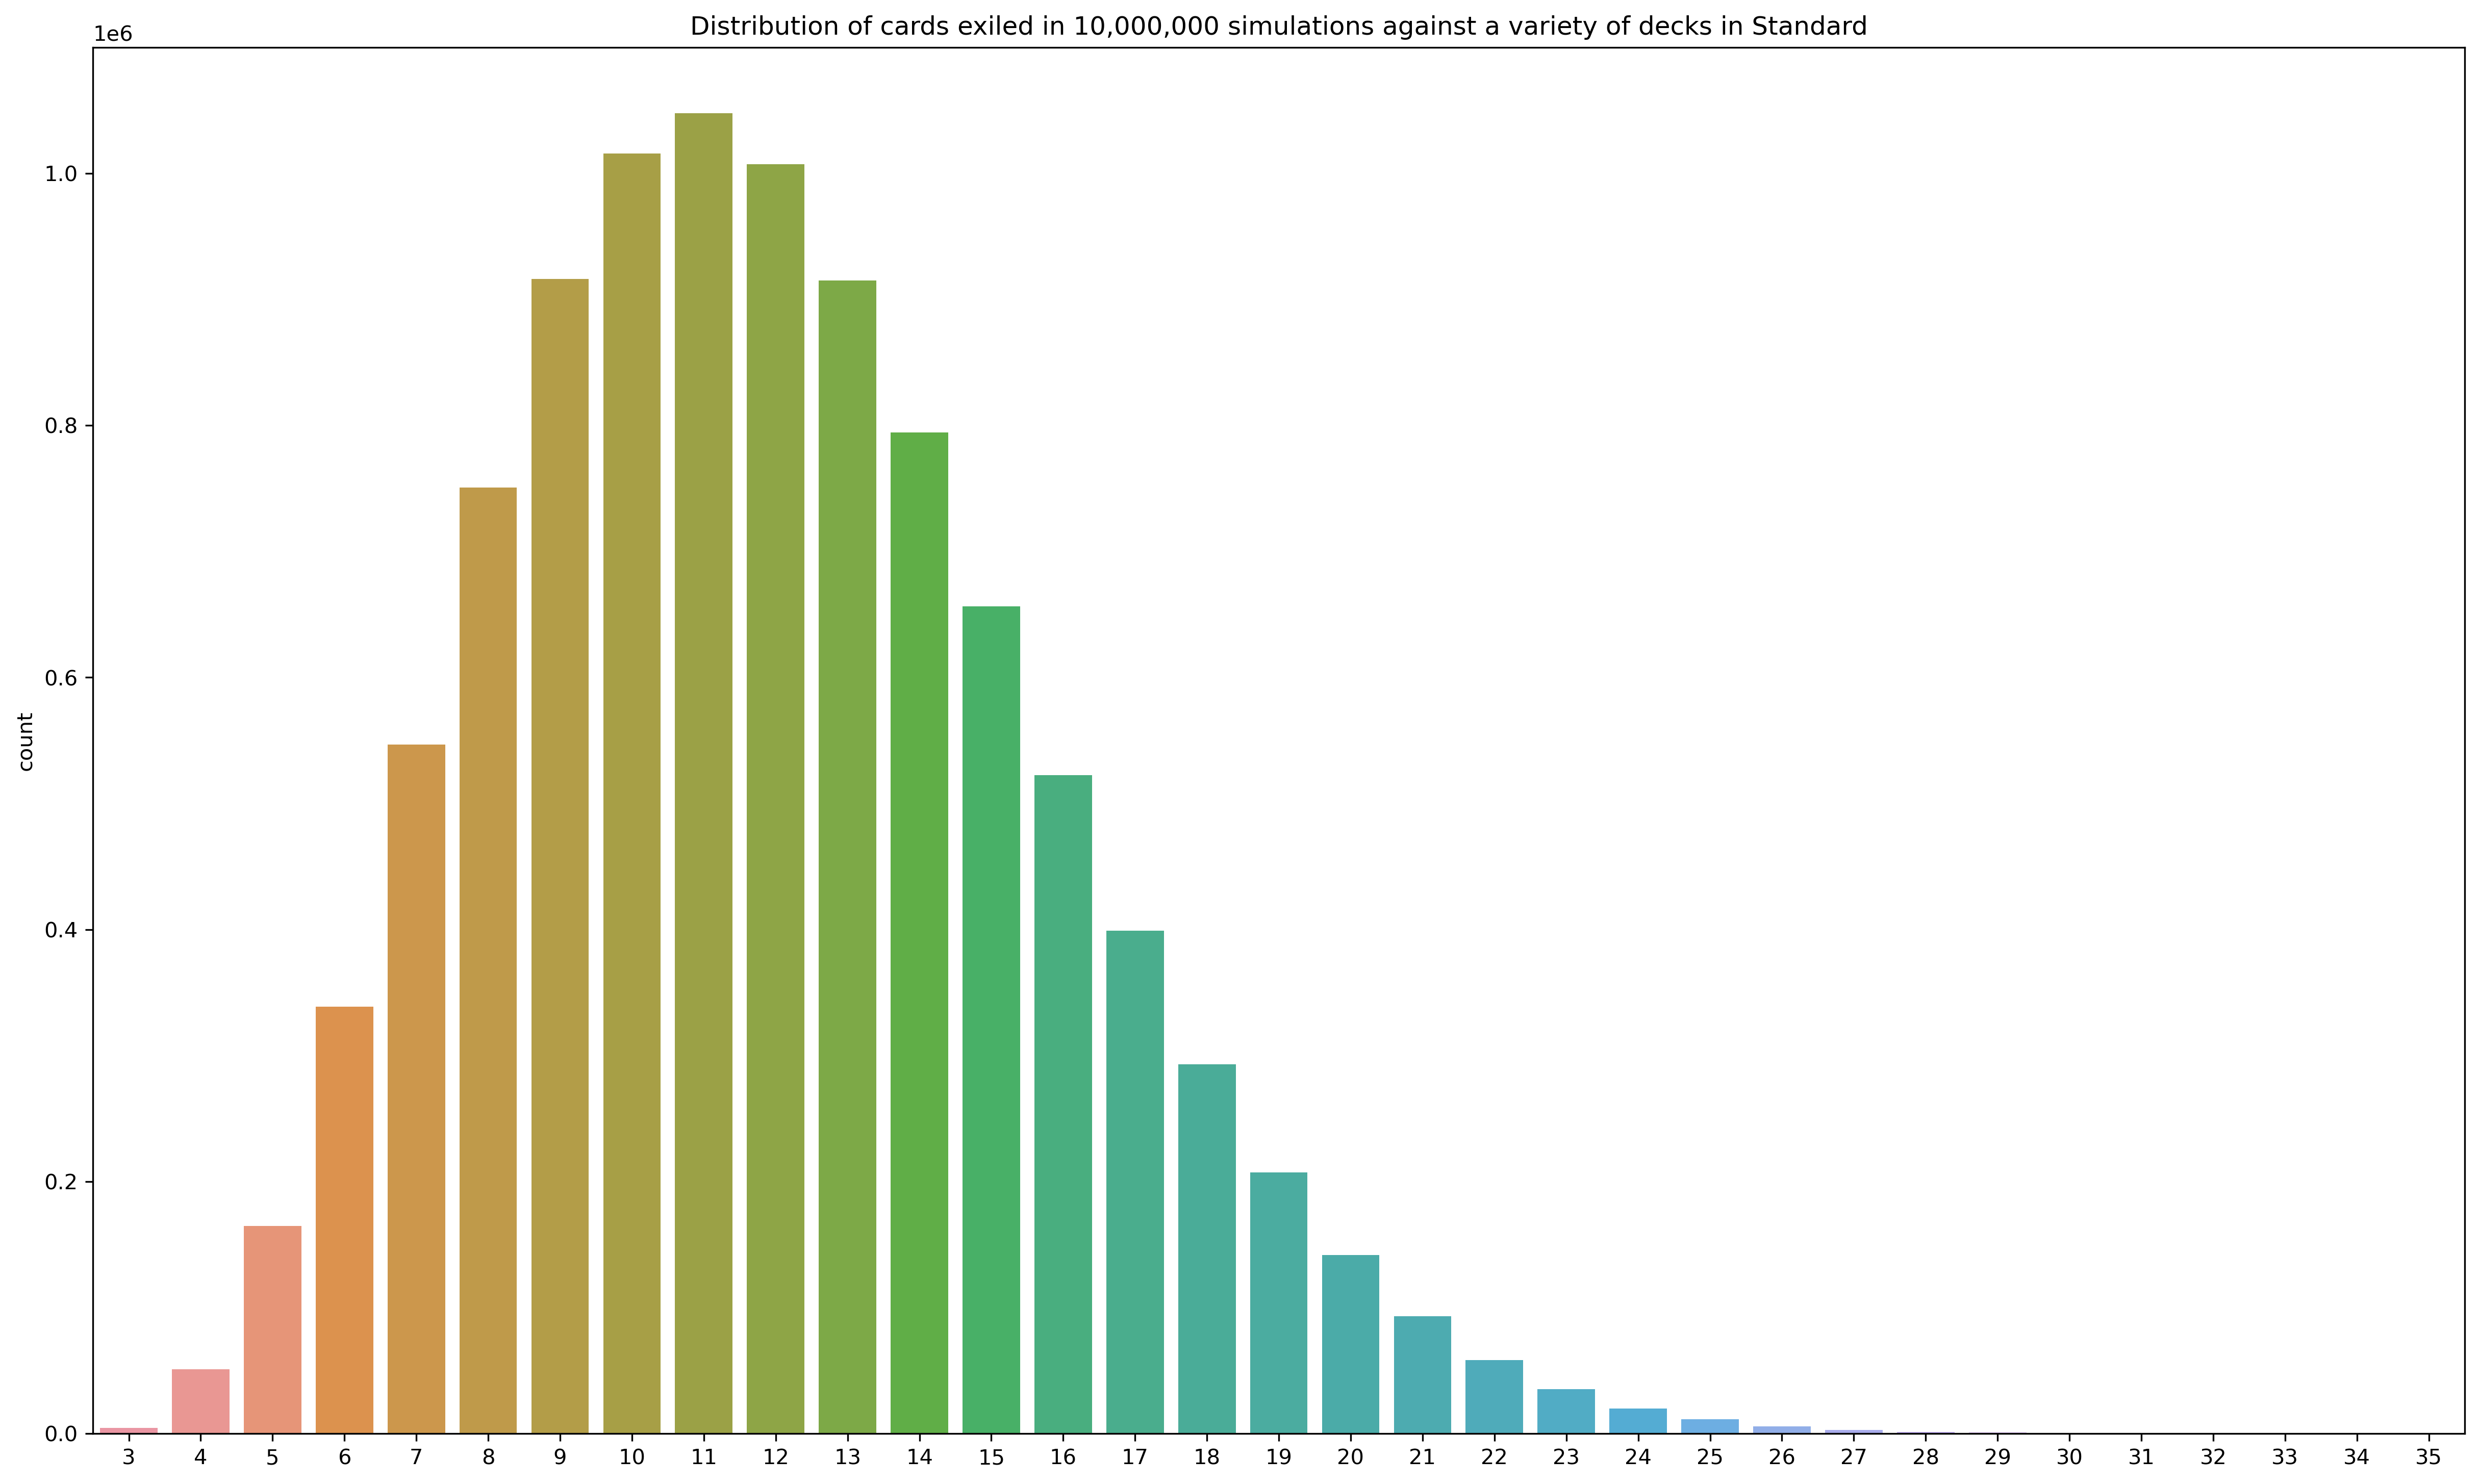

Expected cards exiled: 12.0052402
Against the biggest deck, exp cards exiled was (8.976175, ['2 Professor Onyx', '1 Sea Gate Restoration', "4 Alrund's Epiphany", "1 Shadows' Verdict", '2 Extinction Event', '4 Strategic Planning', '1 Rain of Revelation', '1 Mystical Dispute', '4 Thirst for Meaning', '1 Negate', '2 Curate', '3 Heartless Act', '2 Eliminate', '4 Shark Typhoon', "4 Titans' Nest", '1 Dead Weight', '4 Clearwater Pathway', '1 Darkbore Pathway', '4 Barkchannel Pathway', '4 Zagoth Triome', '4 Fabled Passage', '2 Swamp', '1 Forest', '3 Island'])
Against the second biggest deck, exp cards exiled was (8.9934, ['2 Professor Onyx', "4 Alrund's Epiphany", '1 Sea Gate Restoration', '2 Extinction Event', '4 Strategic Planning', '2 Rain of Revelation', '1 Mystical Dispute', '4 Thirst for Meaning', '1 Negate', '3 Curate', '3 Heartless Act', '2 Eliminate', '4 Shark Typhoon', "4 Titans' Nest", '1 Forest', '2 Darkbore Pathway', '4 Zagoth Triome', '4 Clearwater Pathway', '2 Swamp', '4 Fabled 

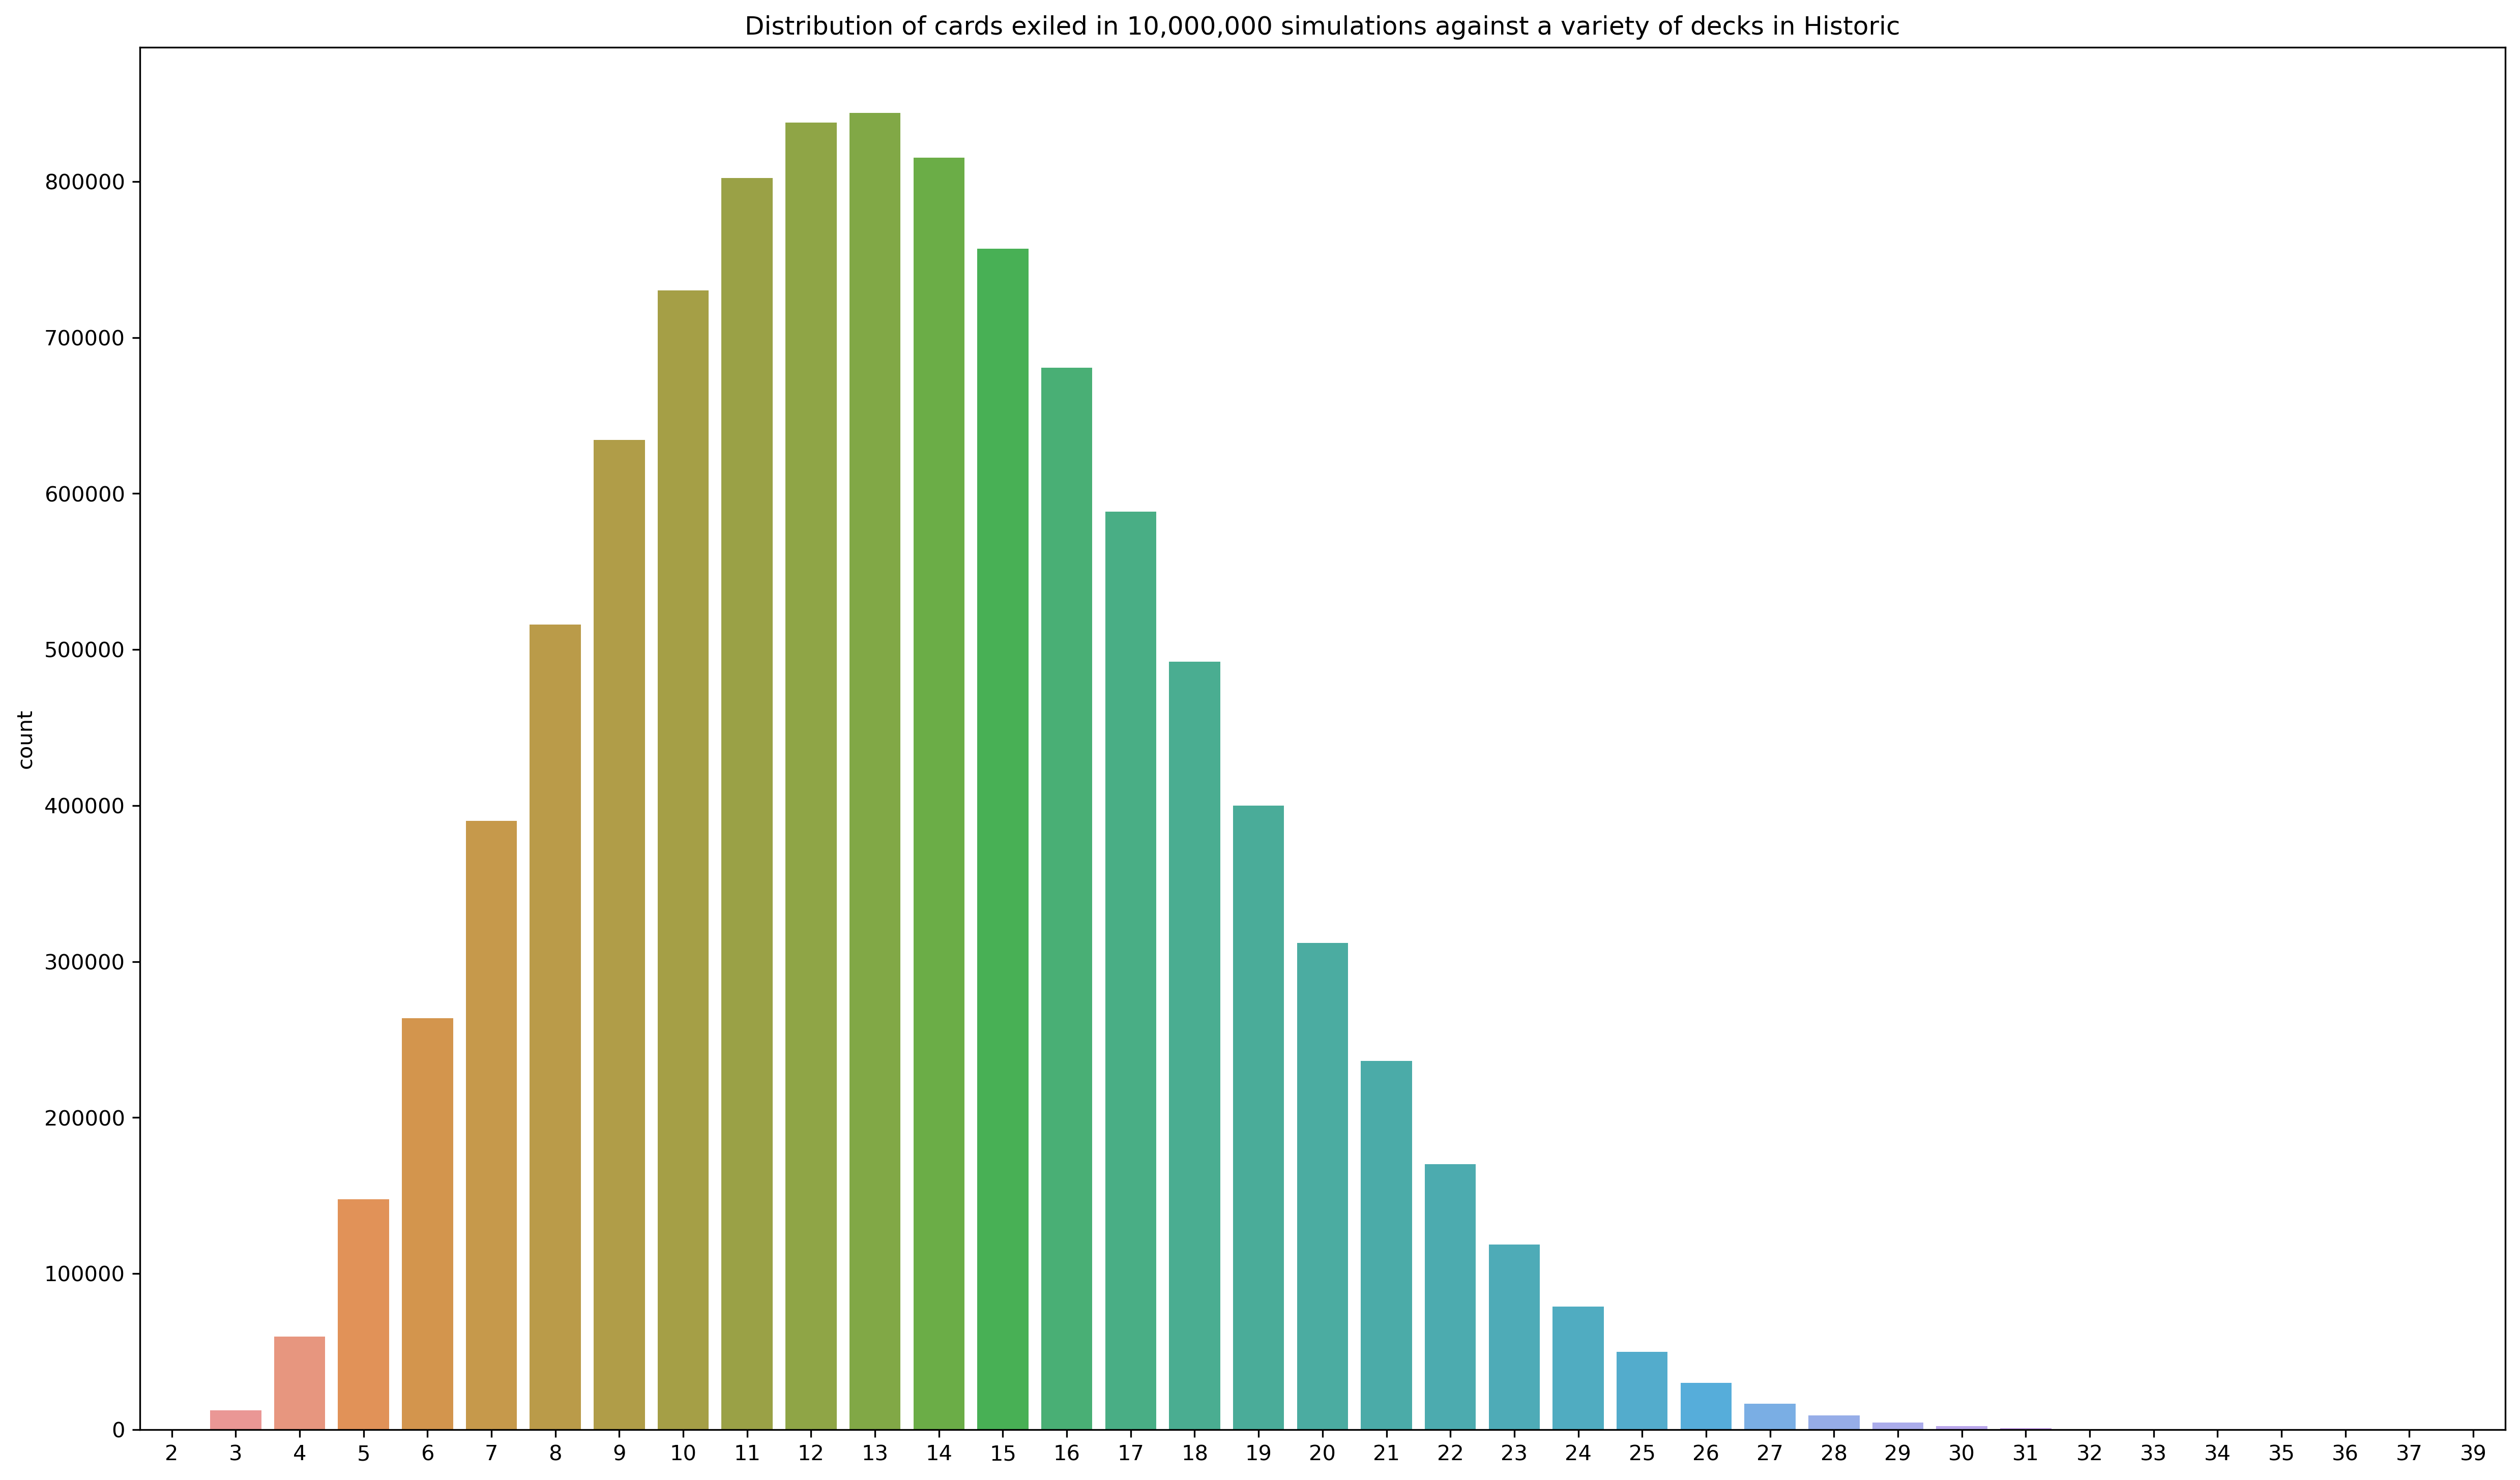

Expected cards exiled: 13.4962651
Against the biggest deck, exp cards exiled was (8.573775, ['3 Ugin, the Spirit Dragon', '2 Ugin, the Ineffable', '4 Karn, the Great Creator', '2 Karn, Scion of Urza', '2 Ulamog, the Ceaseless Hunger', '1 Golos, Tireless Pilgrim', '4 Languish', '3 Forsaken Monument', '3 Hedron Archive', '4 Guardian Idol', '4 Mind Stone', '2 Mazemind Tome', '2 Coldsteel Heart', '2 Swamp', '1 Scavenger Grounds', '4 Radiant Fountain', '1 Cascading Cataracts', '4 Ifnir Deadlands', '1 Blast Zone', '1 Crawling Barrens', '4 Aether Hub', '4 Spire of Industry', '1 Arch of Orazca', '1 Blinkmoth Nexus'])
Against the second biggest deck, exp cards exiled was (8.838325, ['3 Velomachus Lorehold', '4 Time Warp', "4 Mizzix's Mastery", '4 Indomitable Creativity', '3 Anger of the Gods', '4 Magma Opus', '4 Prismari Command', '1 Silundi Vision', '3 Memory Lapse', '4 Brainstorm', '2 Shark Typhoon', '4 Dwarven Mine', '3 Sulfur Falls', '1 Island', '4 Steam Vents', '4 Raugrin Triome', '4 Fable

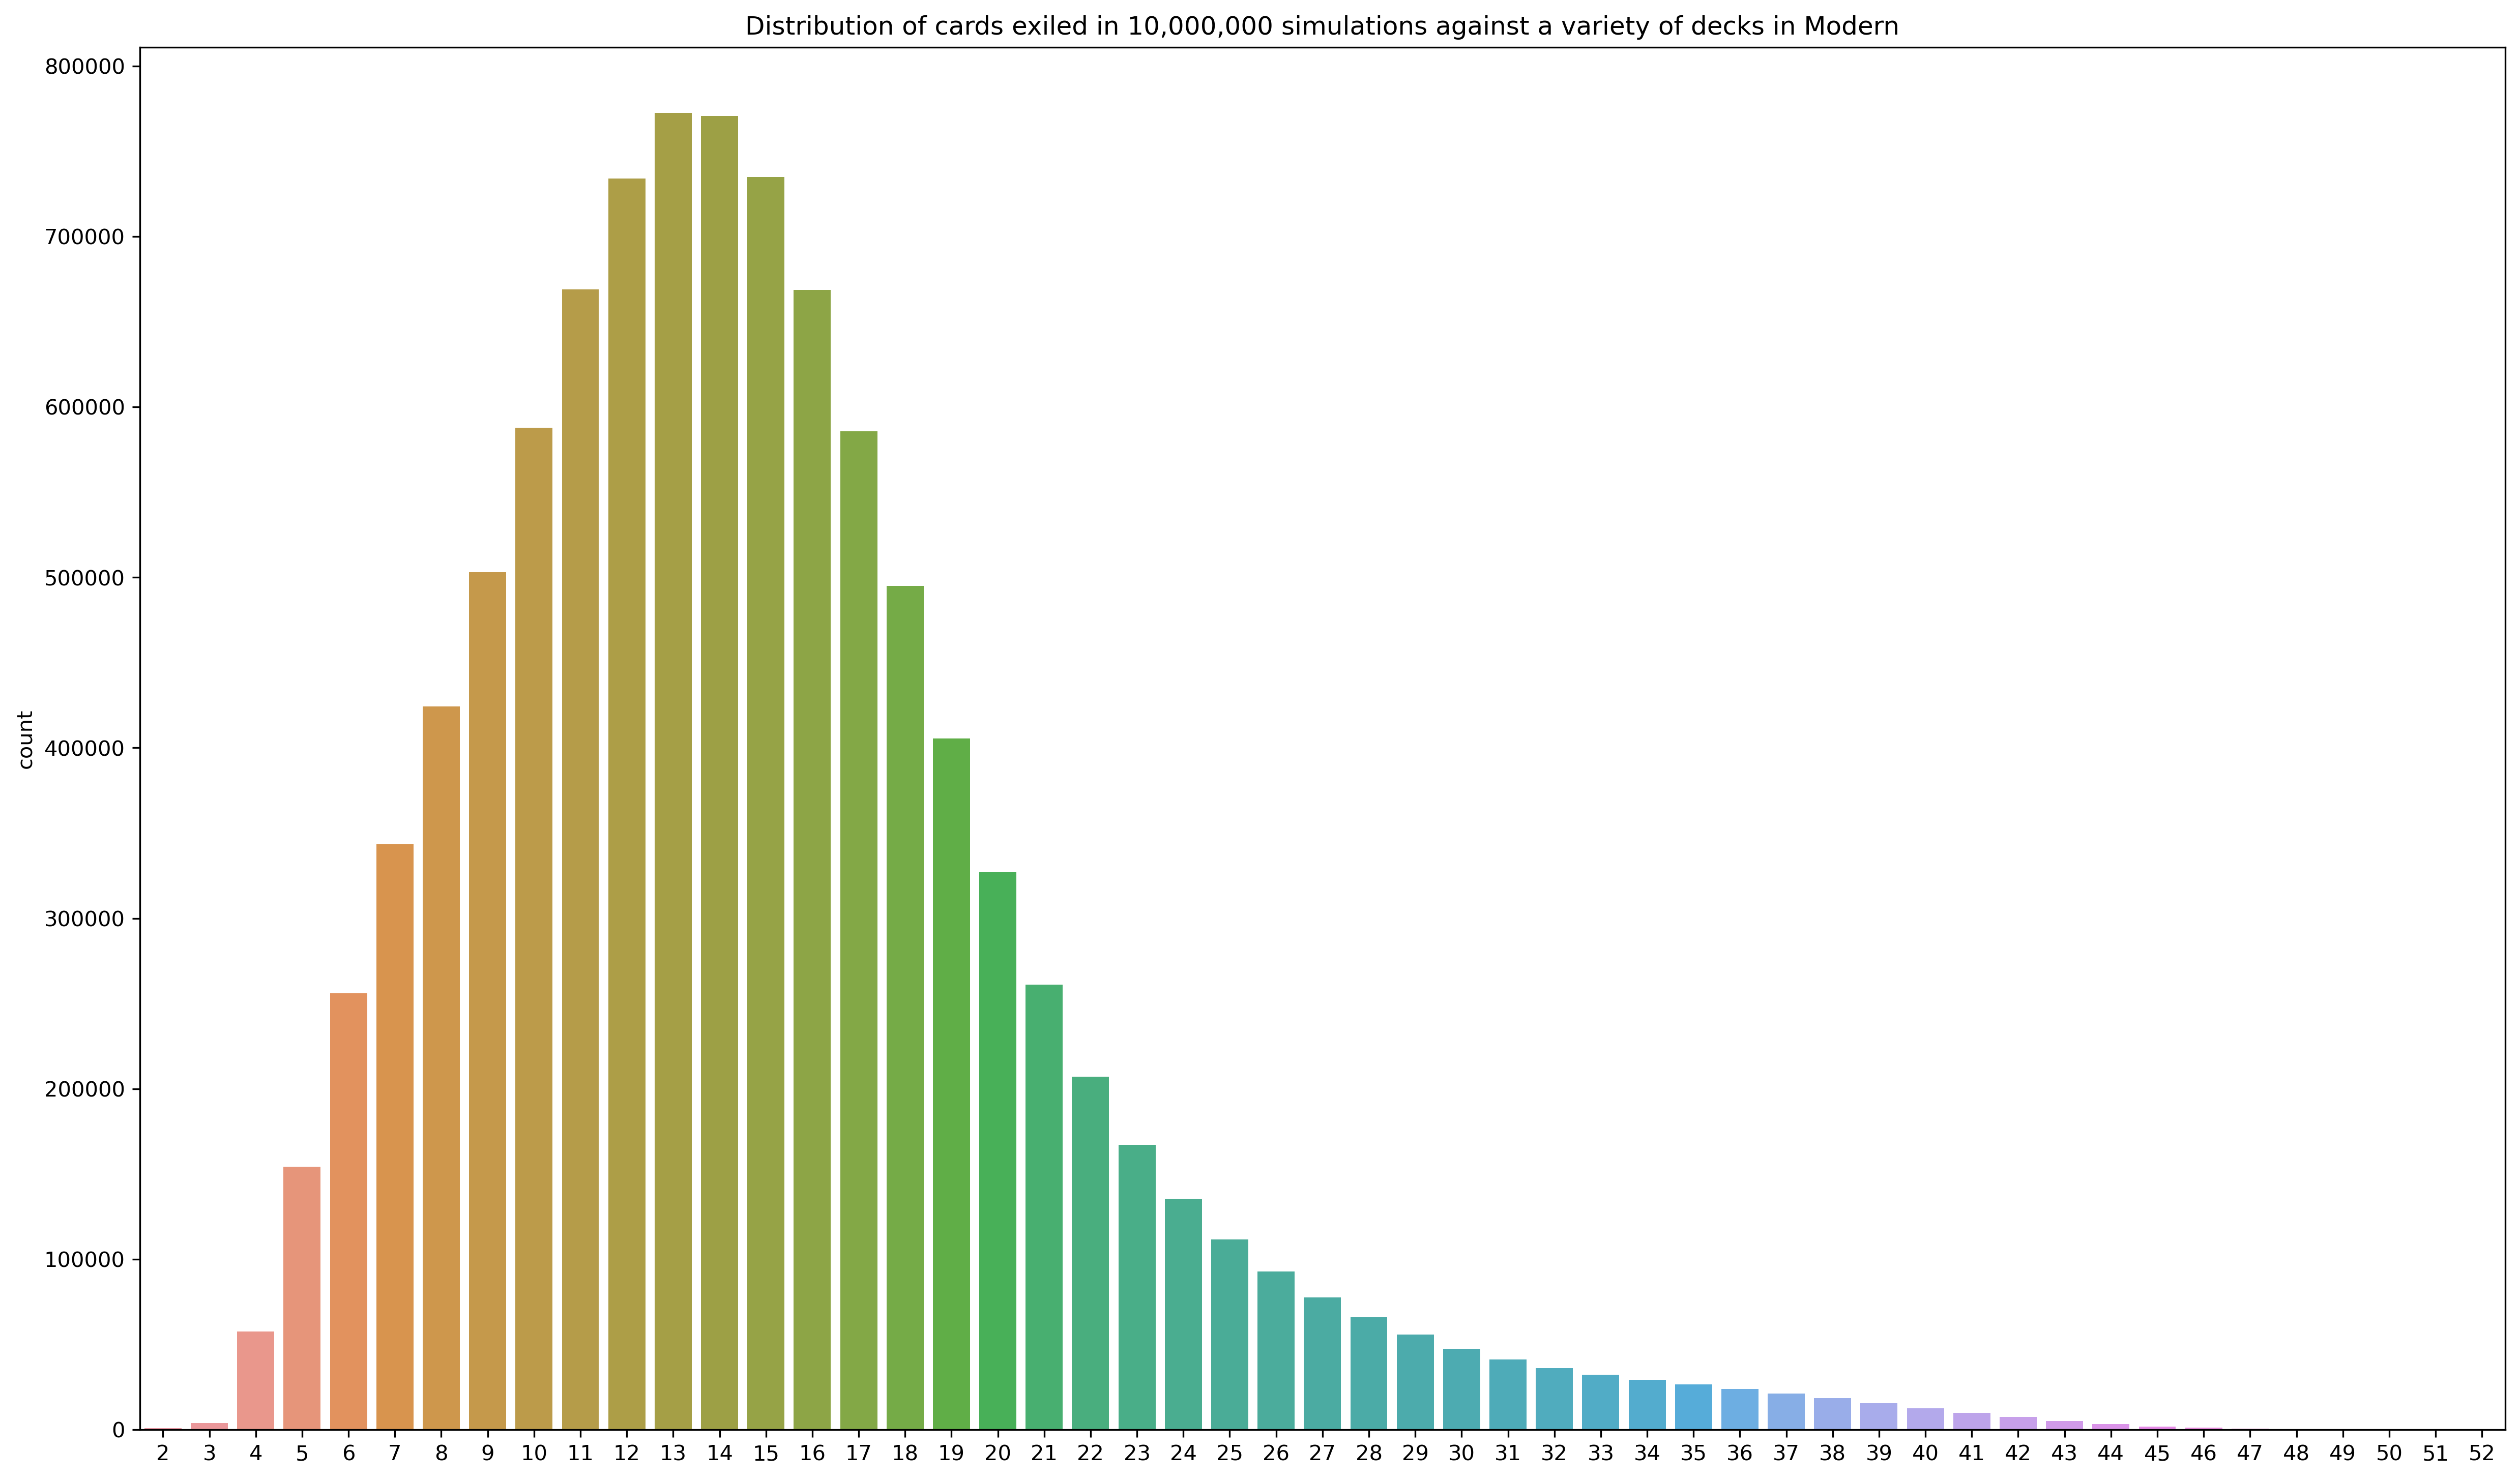

Expected cards exiled: 14.9961625
Against the biggest deck, exp cards exiled was (7.49161, ['2 Brazen Borrower', '4 Curator of Mysteries', '4 Desert Cerodon', '4 Glassdust Hulk', '4 Shardless Agent', '4 Street Wraith', '4 Striped Riverwinder', '4 Windcaller Aven', '4 Living End', '4 Force of Negation', '4 Violent Outburst', '4 Botanical Sanctum', '1 Breeding Pool', '1 Flooded Strand', '1 Forest', '1 Island', '4 Misty Rainforest', '1 Polluted Delta', '4 Spirebluff Canal', '1 Steam Vents'])
Against the second biggest deck, exp cards exiled was (7.49697, ['2 Brazen Borrower', '4 Curator of Mysteries', '4 Desert Cerodon', '4 Glassdust Hulk', '4 Shardless Agent', '4 Street Wraith', '4 Striped Riverwinder', '4 Windcaller Aven', '4 Living End', '4 Force of Negation', '4 Violent Outburst', '4 Botanical Sanctum', '1 Breeding Pool', '1 Flooded Strand', '1 Forest', '1 Island', '4 Misty Rainforest', '1 Polluted Delta', '4 Spirebluff Canal', '1 Steam Vents'])
Against the second smallest deck, exp c

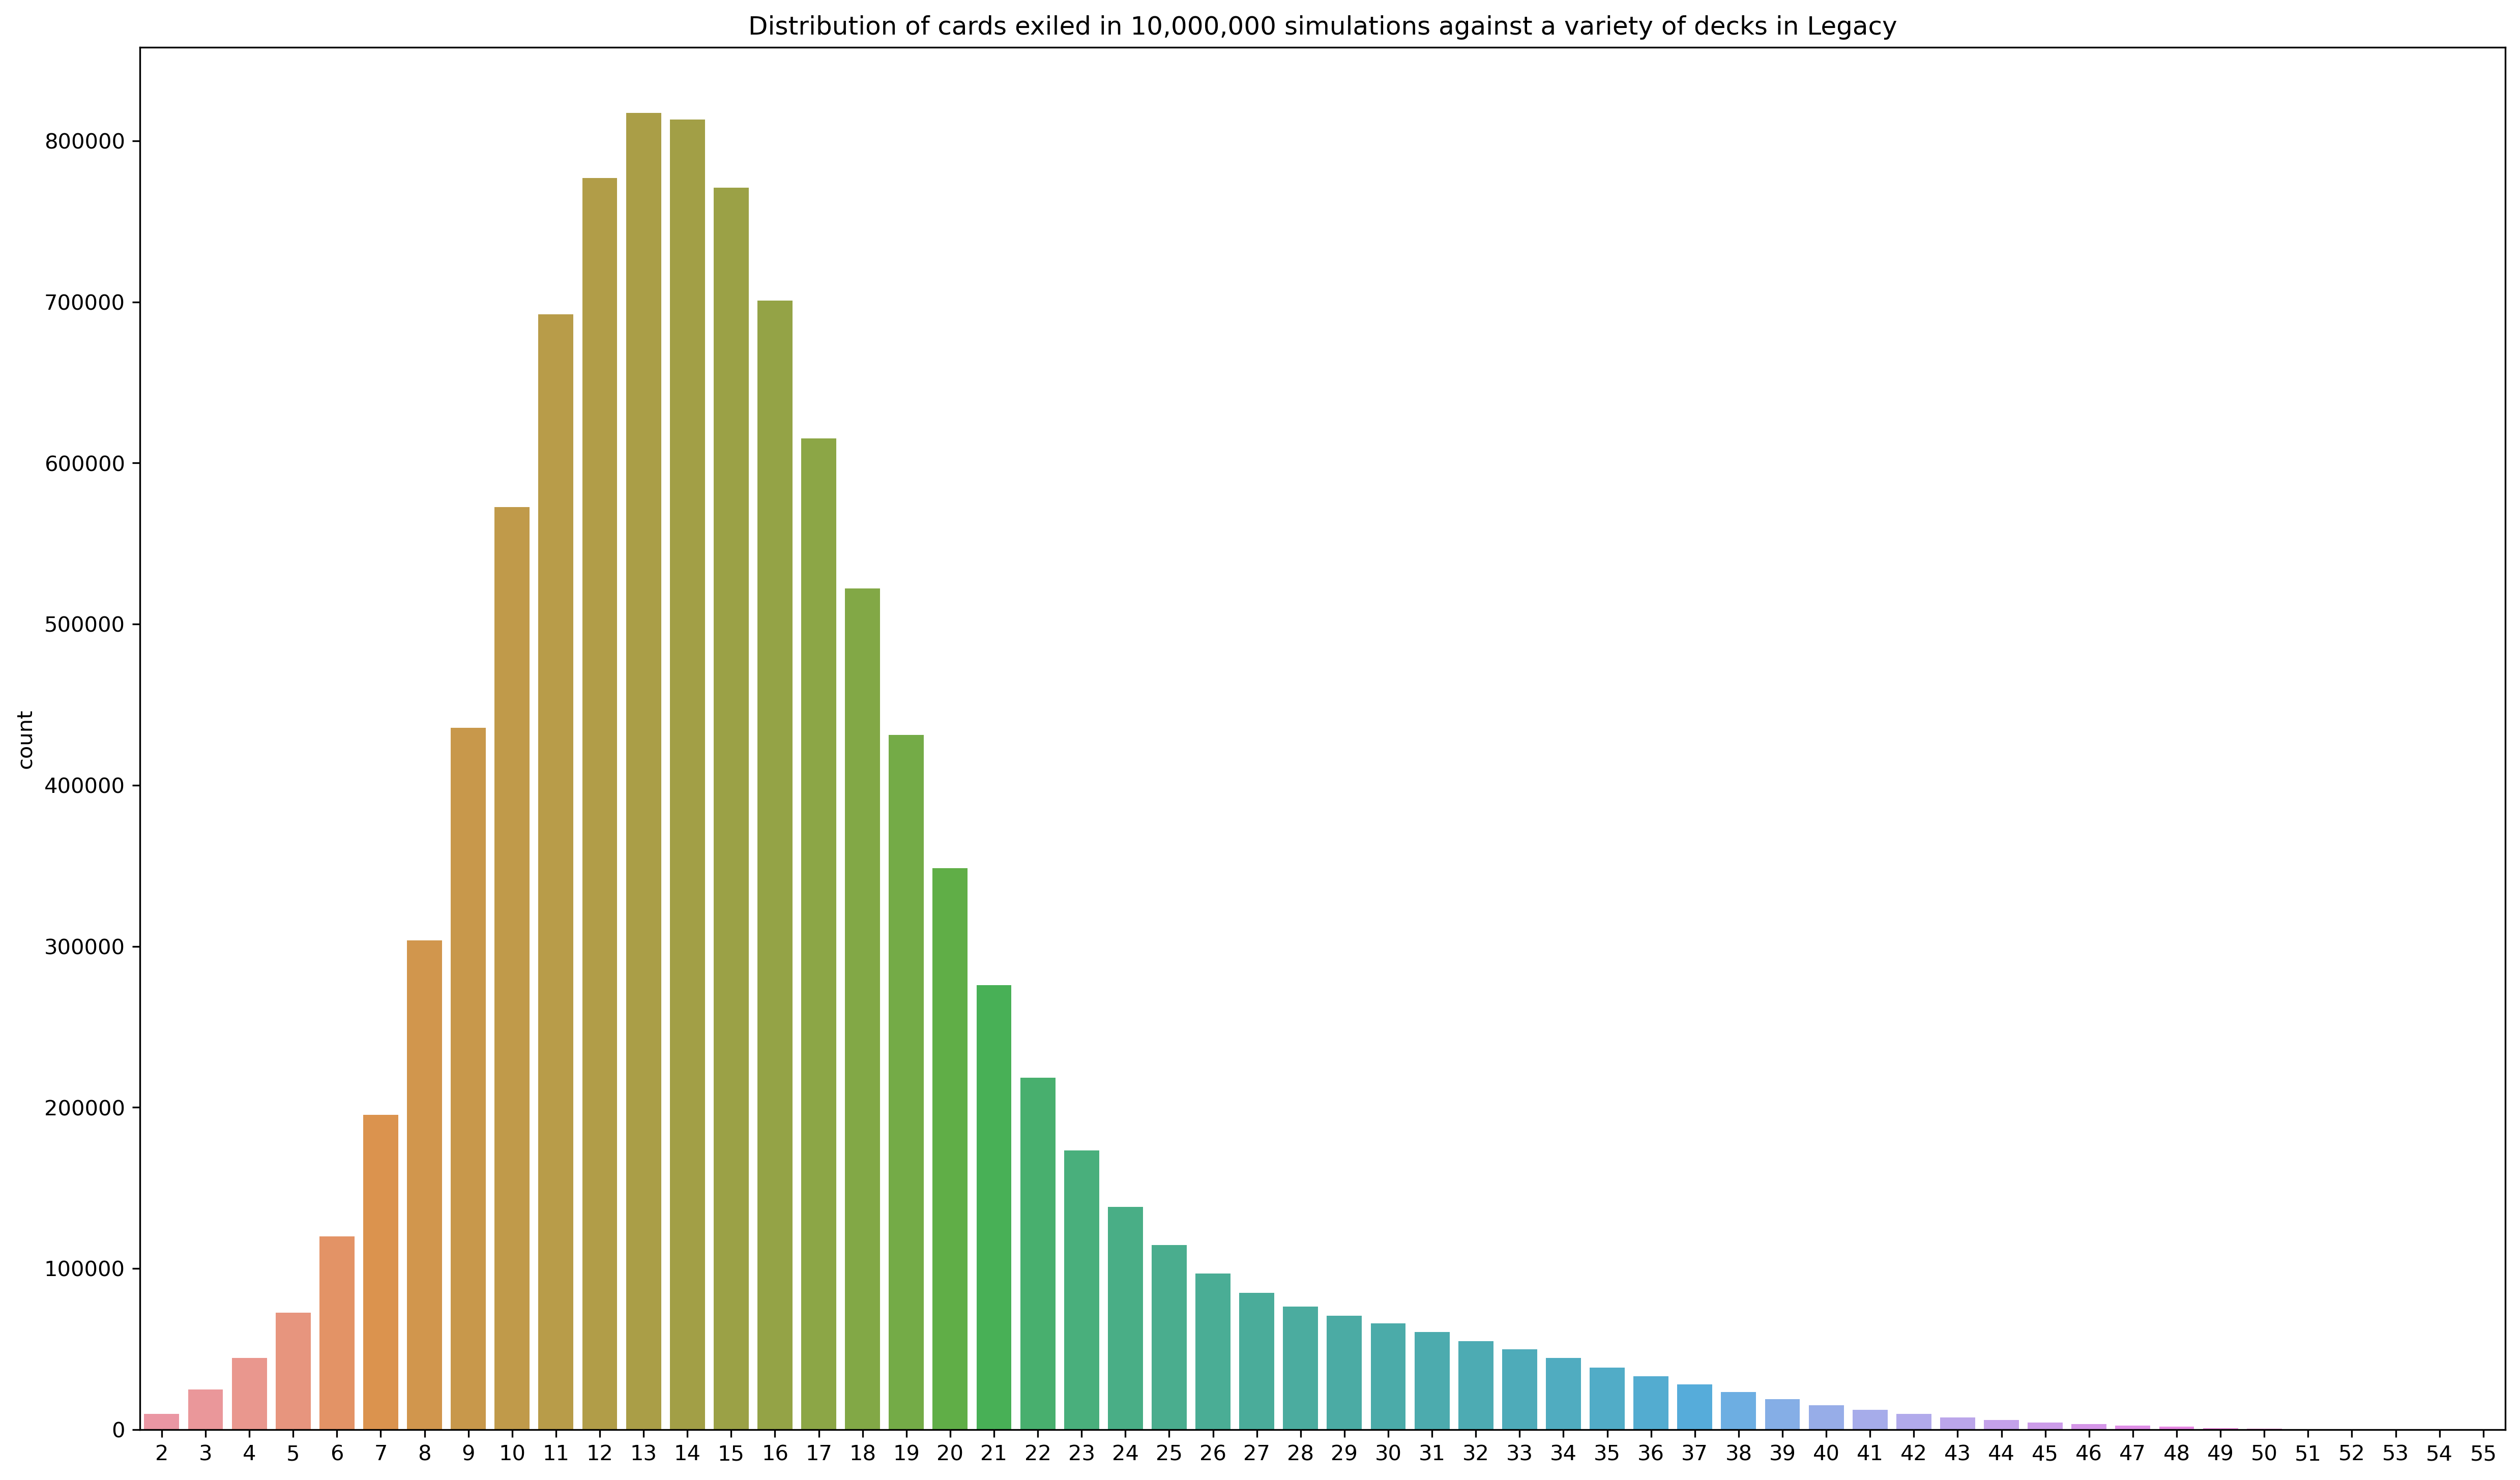

Expected cards exiled: 15.8064563
Against the biggest deck, exp cards exiled was (8.02459, ['3 Emrakul, the Aeons Torn', '3 Griselbrand', '4 Ponder', '4 Show and Tell', '4 Brainstorm', '3 Cunning Wish', '2 Daze', '4 Force of Will', '2 Impulse', '1 Intuition', '1 Spikefield Hazard', '4 Lotus Petal', '3 Omniscience', '3 Sneak Attack', '3 Ancient Tomb', '1 Boseiju, Who Shelters All', '2 City of Traitors', '1 Flooded Strand', '1 Polluted Delta', '4 Scalding Tarn', '3 Snow-Covered Island', '1 Snow-Covered Mountain', '3 Volcanic Island'])
Against the second biggest deck, exp cards exiled was (8.02893, ['3 Emrakul, the Aeons Torn', '3 Griselbrand', '4 Ponder', '4 Show and Tell', '4 Brainstorm', '3 Cunning Wish', '2 Daze', '4 Force of Will', '2 Impulse', '1 Intuition', '1 Spikefield Hazard', '4 Lotus Petal', '3 Omniscience', '3 Sneak Attack', '3 Ancient Tomb', '1 Boseiju, Who Shelters All', '2 City of Traitors', '1 Flooded Strand', '1 Polluted Delta', '4 Scalding Tarn', '3 Snow-Covered Island'

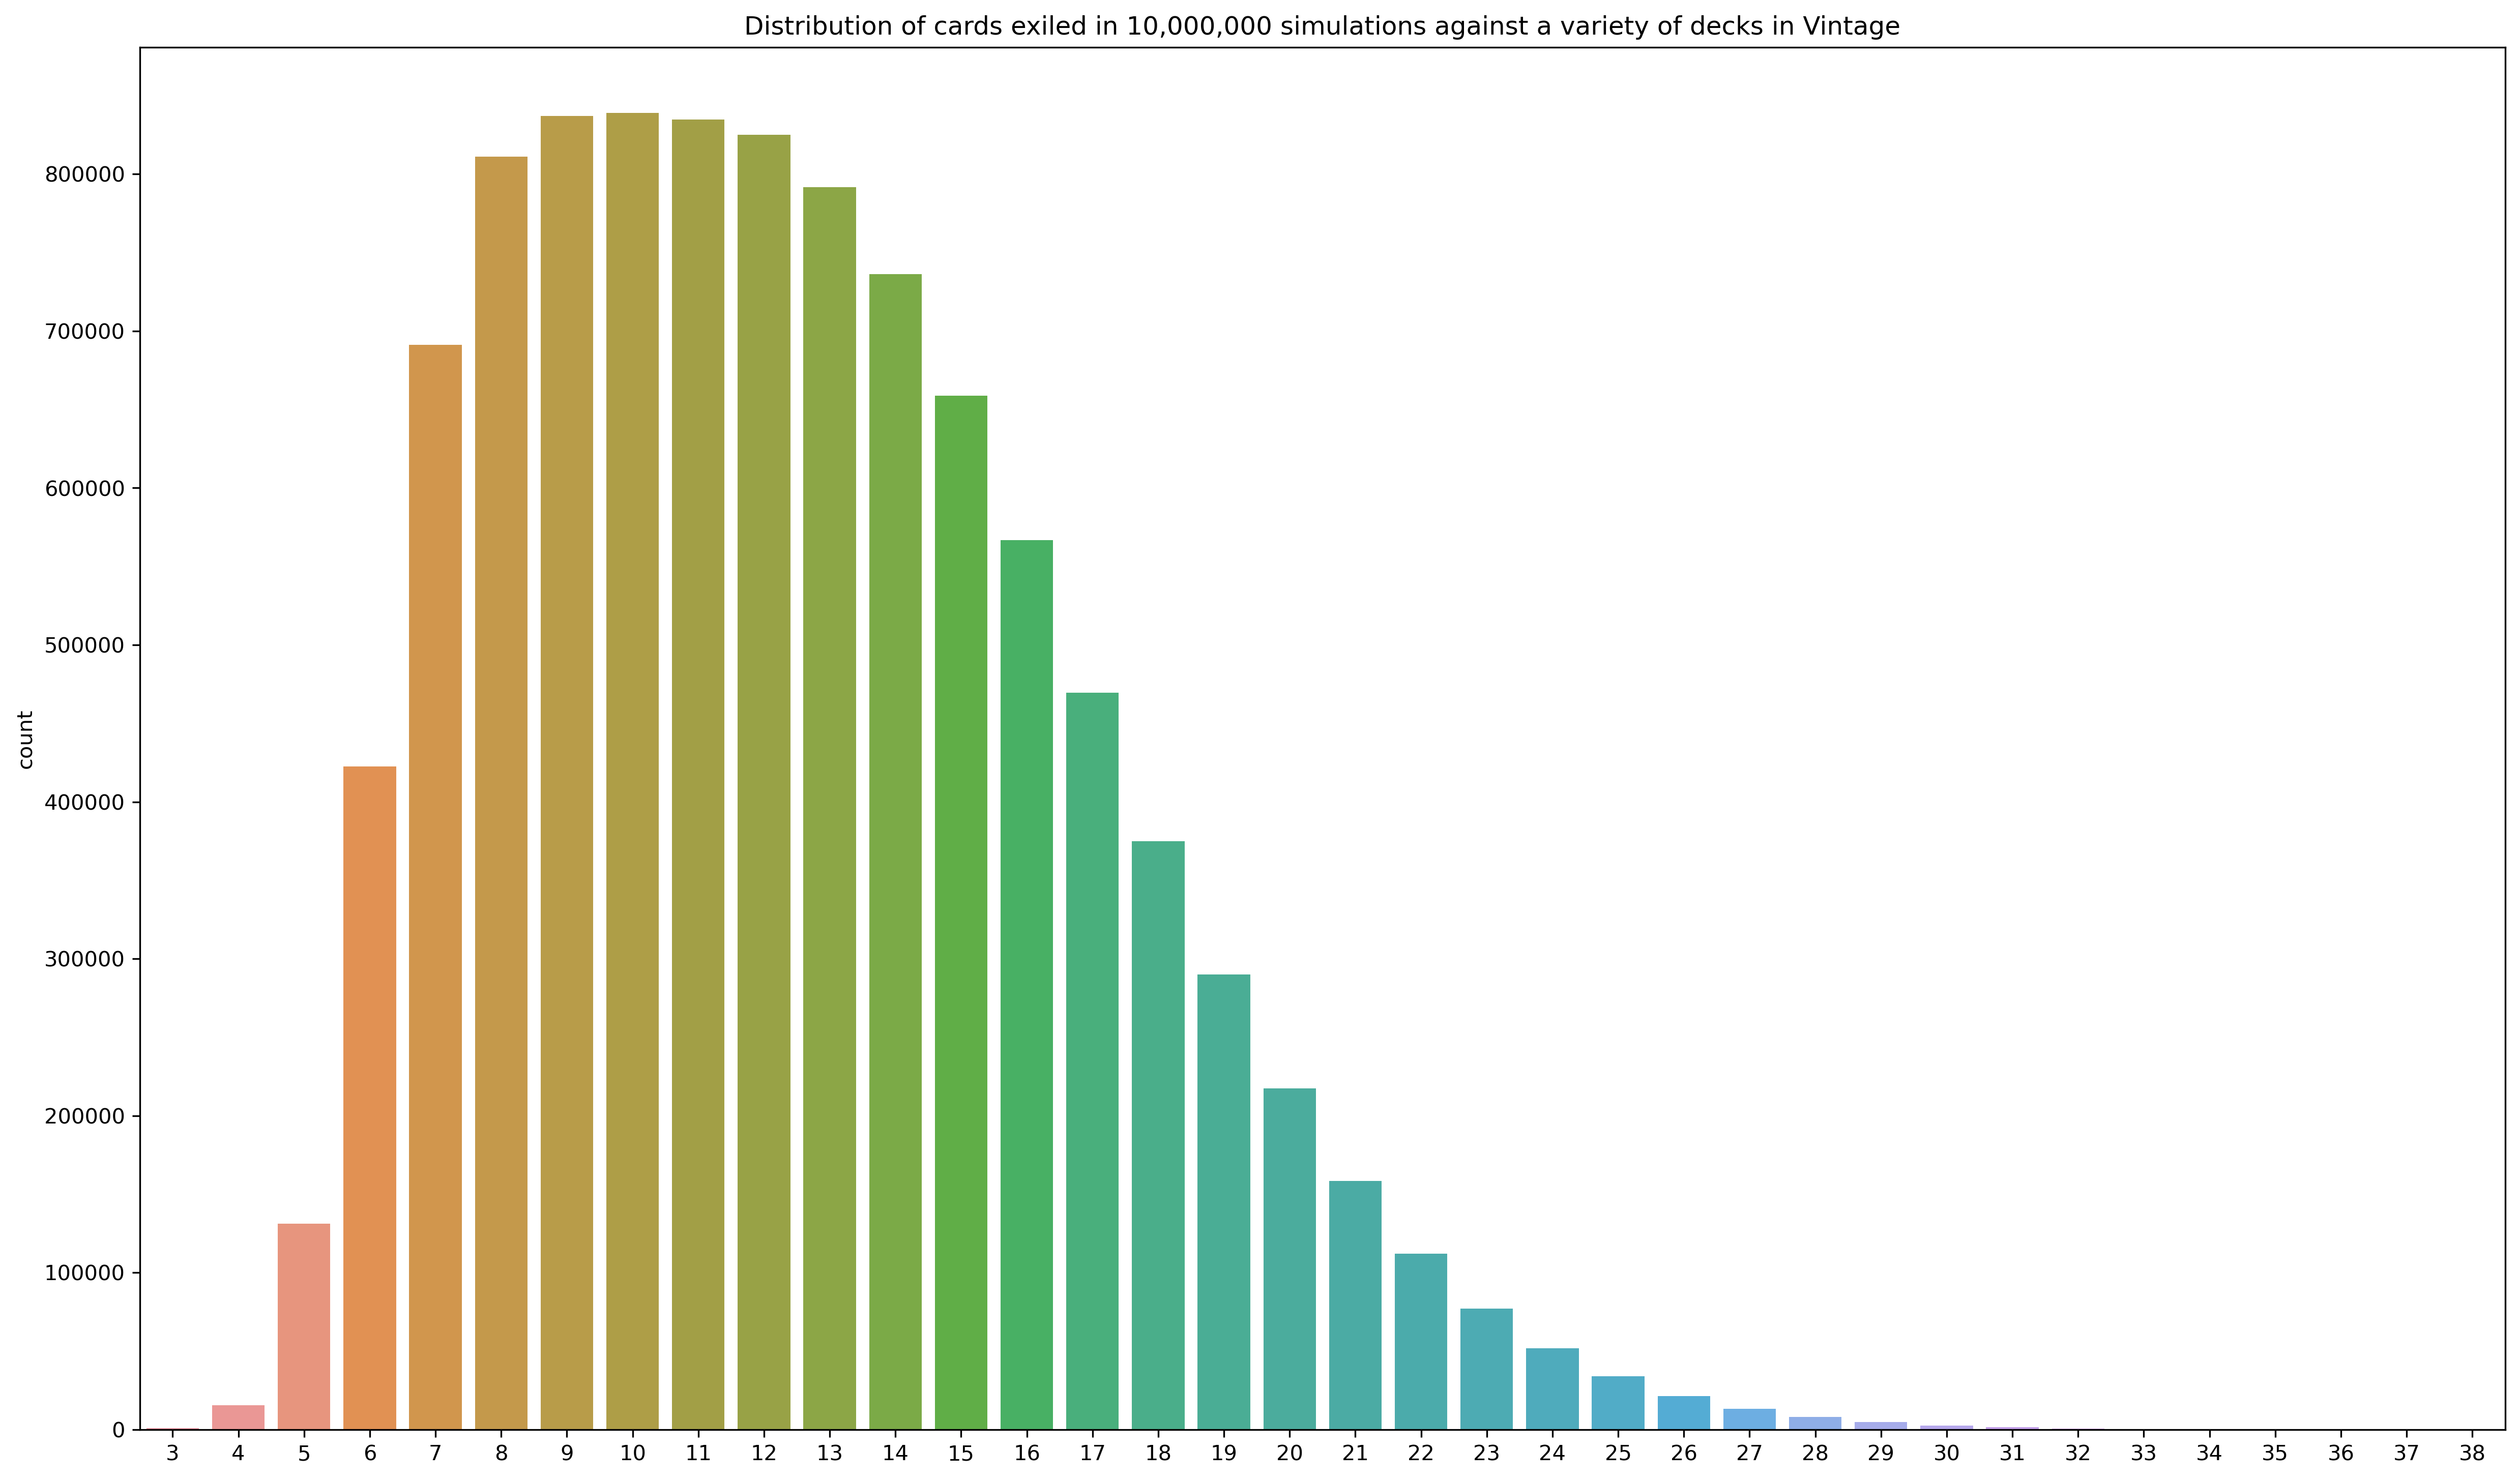

Expected cards exiled: 12.4834238
Against the biggest deck, exp cards exiled was (7.19767, ['1 Golgari Grave-Troll', '2 Golgari Thug', '4 Grief', '4 Hollow One', '4 Ichorid', '4 Narcomoeba', '4 Prized Amalgam', '4 Shambling Shell', '4 Stinkweed Imp', '4 Cabal Therapy', '4 Creeping Chill', '1 Gitaxian Probe', '4 Force of Will', '1 Mental Misstep', '2 Noxious Revival', '4 Serum Powder', '4 Bridge from Below', '1 Leyline of the Void', '4 Bazaar of Baghdad'])
Against the second biggest deck, exp cards exiled was (7.36217, ['1 Golgari Grave-Troll', '2 Golgari Thug', '4 Grief', '4 Hollow One', '4 Ichorid', '4 Narcomoeba', '4 Prized Amalgam', '4 Shambling Shell', '4 Stinkweed Imp', '4 Cabal Therapy', '4 Creeping Chill', '1 Gitaxian Probe', '4 Force of Will', '1 Mental Misstep', '2 Noxious Revival', '1 Chalice of the Void', '4 Serum Powder', '4 Bridge from Below', '4 Bazaar of Baghdad'])
Against the second smallest deck, exp cards exiled was (17.77268, ['4 Archon of Emeria', '3 Leonin Relic-Wa

In [4]:
for mtg_format in ['Standard', 'Historic', 'Modern', 'Legacy', 'Vintage']:
    list_of_decks = give_decklists(mtg_format)
    nr_decks = len(list_of_decks)
    nr_sims_per_deck = 100000 if mtg_format in ['Modern', 'Legacy', 'Vintage'] else 40000
    total_sims = nr_decks * nr_sims_per_deck
    #We'll simulate each deck nr_sims_per_deck times
    #We'll store the outcome (cards_exiled) of each sim in a list cards_exiled_list
    #We'll store a tuple (the expected cards exiled, decklist) of each deck in a list exp_exile_per_deck
    cards_exiled_list = []
    exp_exile_per_deck = []

    for deck in list_of_decks:
        total_exiled_for_this_deck = 0
        for _ in range(nr_sims_per_deck):
            sim_outcome = simulate(deck)
            cards_exiled_list.append(sim_outcome)
            total_exiled_for_this_deck += sim_outcome
        exp_exile_per_deck.append((total_exiled_for_this_deck / nr_sims_per_deck, deck['decklist']))
    plt.figure(figsize=(20,12), dpi = 300)
    exp_exile_per_deck.sort()
    sns.countplot(x=cards_exiled_list).set_title(f'Distribution of cards exiled in {total_sims:,} simulations against a variety of decks in {mtg_format}')
    plt.show()
    print('Expected cards exiled:', sum(cards_exiled_list) / total_sims)
    print('Against the biggest deck, exp cards exiled was', exp_exile_per_deck[0])
    print('Against the second biggest deck, exp cards exiled was', exp_exile_per_deck[1])
    print('Against the second smallest deck, exp cards exiled was', exp_exile_per_deck[nr_decks - 2])
    print('Against the smallest deck, exp cards exiled was', exp_exile_per_deck[nr_decks - 1])